<a href="https://colab.research.google.com/github/marco-luzzara/boardgame-complexity-predictor/blob/features_weights/src/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U scikit-learn

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
x_all, y_all = df_features.iloc[:, 1:], df_features.iloc[:, 0]
features_count = len(x_all.columns)
df_features.head()

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


,averageweight,playingtime,rulebook_len,dice_luck_metric,drawing_luck_metric,shuffling_luck_metric,random_luck_metric,can_metric,choices_metric,entities_count,...,lexical_richness,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,unspecified,wargames
0,2.1579,60,3155.0,0.0,0.000000,0.147710,0.000000,0.590842,0.295421,5.0,...,41.315934,0,0,0,1,0,0,0,0,0
1,3.1452,90,73093.0,0.0,0.013557,0.027113,0.027113,1.342100,0.135566,62.0,...,50.435229,0,0,0,0,0,1,0,0,0
2,1.8100,90,20155.0,0.0,0.000000,0.000000,0.000000,0.911927,0.143988,39.0,...,39.196724,0,0,0,0,0,0,1,0,0
3,1.4858,30,13866.0,0.0,0.413936,0.137979,0.000000,0.551914,0.275957,14.0,...,51.914286,0,0,0,1,0,0,0,0,0
4,2.7813,120,3604.0,0.0,0.000000,0.000000,0.000000,0.583090,1.020408,8.0,...,52.789001,0,0,0,0,0,1,0,0,0


In [2]:
import logging

logger = logging.getLogger('bgg_predict')
logger.handlers.clear()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [3]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def custom_cv_stratified_regression(fold_count: int, 
                                    x, y, 
                                    train_size = None, test_size = None,
                                    random_state = None) -> Generator[Tuple[List[int], List[int]], None, None]:
    '''this stratified splitter equally distributes the rows in each split. In this way,
    the same split will have easy, medium and hard board games equally distributed'''                                    
    splitter = StratifiedShuffleSplit(n_splits=fold_count, 
                                      train_size = train_size, test_size = test_size,
                                      random_state = random_state)
    # avg * 2 gives at most 10 classes
    weights_categories = y.squeeze().apply(lambda avg: round(avg * 2))
    for train_indices, test_indices in splitter.split(x, weights_categories):
        yield train_indices, test_indices

def train_test_stratified_split(x, y, 
                                train_size = None, test_size = None,
                                random_state = None):
    splitter = custom_cv_stratified_regression(1, x, y, 
                                               train_size, test_size, random_state = random_state)
    train_indices, test_indices = next(splitter)
    return x.iloc[train_indices], x.iloc[test_indices],\
           y.iloc[train_indices], y.iloc[test_indices]

estimator_cachedir = mkdtemp()
class Model:
    def __get_class_name(self, component):
        cls_name = component.__class__.__name__
        if cls_name == 'ColumnTransformer':
            cls_name = ' + '.join(trf[1].__class__.__name__ for trf in component.transformers)
        if cls_name == 'RFECV':
            cls_name = f'RFECV({component.estimator.__class__.__name__})'

        return cls_name

    def __init__(self, components, params_tuning = None):
        self.name = ' + '.join(self.__get_class_name(component[1]) for component in components)
        self.instance = Pipeline(components, memory = estimator_cachedir)
        self.params_tuning = params_tuning

In [4]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List
from sklearn.metrics import PredictionErrorDisplay

MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def fill_predictions_subplot(ax, i_model: int, title: str, y_test, y_predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW

    subplot = ax[row][col]
    subplot.grid(True)
    PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_predictions,
        kind="actual_vs_predicted",
        ax=subplot,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    subplot.set_title(title)

def create_containing_plot(suptitle: str, plot_id: int, subplots_count):
    containing_plot_rows = math.ceil(subplots_count / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    fig.suptitle(suptitle, fontsize=15)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - subplots_count):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

In [5]:
from collections import namedtuple
from typing import Tuple, Any, Dict, Optional
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV

PerformanceMetrics = namedtuple('PerformanceMetrics', ['r2', 'mae', 'mape', 'mse'])
FitEstimatorResults = Tuple[Any, PerformanceMetrics, Optional[Dict[str, Any]]]

def get_fit_estimator(estimator, x_train, y_train, splitter, cv_scorings) \
        -> FitEstimatorResults:
    cv_results = cross_validate(estimator, 
                                x_train, y_train,
                                cv = splitter,
                                scoring = cv_scorings)
    estimator.fit(x_train, y_train)

    r2   = np.mean(cv_results['test_r2'])
    mae  = abs(np.mean(cv_results['test_neg_mean_absolute_error']))
    mape = abs(np.mean(cv_results['test_neg_mean_absolute_percentage_error']))
    mse  = abs(np.mean(cv_results['test_neg_mean_squared_error']))
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics, None

def get_fit_estimator_with_tuning(estimator, params, x_train, y_train, \
                                  splitter, cv_scorings) -> FitEstimatorResults:
    # refit needs an existing scoring
    assert 'neg_mean_absolute_error' in cv_scorings
    search = GridSearchCV(estimator,
                          params,
                          cv = splitter,
                          error_score='raise',
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1, 
                          scoring = cv_scorings,
                          return_train_score = True)
    
    search.fit(x_train, y_train)
    estimator = search.best_estimator_

    r2   = search.cv_results_['mean_test_r2'][search.best_index_]
    mae  = abs(search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_])
    mape = abs(search.cv_results_['mean_test_neg_mean_absolute_percentage_error'][search.best_index_])
    mse  = abs(search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_])
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics, search.best_params_

# Preprocessing

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from typing import List, Tuple, Any

# def build_column_transformer(*transformers: Tuple[Any, List[str]]):
#     return ColumnTransformer([(f'trf{i}', *trf) for i, trf in enumerate(transformers)], \
#                              remainder='passthrough')

# features_to_scale = ['playingtime', 'rulebook_len', 'dice_luck_metric',
#     'drawing_luck_metric', 'shuffling_luck_metric', 'random_luck_metric',
#     'can_metric', 'choices_metric', 'entities_count', 'interaction_score',
#     'entities_variance', 'actions_score']

trf_minmax = MinMaxScaler() #build_column_transformer((MinMaxScaler(), features_to_scale))
trf_maxabs = MaxAbsScaler() #build_column_transformer((MaxAbsScaler(), features_to_scale))
trf_robust = RobustScaler() #build_column_transformer((RobustScaler(), features_to_scale))
trf_standard = StandardScaler() #build_column_transformer((StandardScaler(), features_to_scale))
trf_none = None

trf = trf_minmax
trfs = [trf_robust]#, trf_none]

# build_column_transformer((trf, features_to_scale))

# Feature Selection

In [7]:
from sklearn.feature_selection import SelectKBest, RFECV, SelectFromModel, mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import ShuffleSplit

# only for coefficients-based models
def build_estimator_with_rfecv(estimator):
    return RFECV(
        estimator=estimator,
        step=1,
        cv=ShuffleSplit(5, test_size = 0.2, random_state = 0),
        scoring="r2",
        min_features_to_select=5,
        n_jobs=-1
    )

kbest = SelectKBest(mutual_info_regression)

selectors = [kbest]

# Models

In [11]:
from sklearn import linear_model, svm, kernel_ridge, neighbors, tree, neural_network, ensemble
from typing import Dict, List, Any, Union
from scipy import stats

def build_model(scaler, feature_selector, estimator, 
                params: Dict[str, Union[List[Any], object]] = None) -> Model:
    pipeline = []
    if scaler is not None:
        pipeline.append(('scaler', scaler))
    if feature_selector is not None:
        pipeline.append(('feature_selector', feature_selector))
    pipeline.append(('estimator', estimator))
    return Model(pipeline, params)

def build_model_variances(scalers, feature_selectors, estimator, 
                          params: Dict[str, Union[List[Any], object]] = None) -> List[Model]:
    return [build_model(scaler, selector, estimator, params)
            for scaler in (scalers or [None])
            for selector in (feature_selectors or [None])]
            


models: Dict[str, List[Model]] = {
    'Linear Models': [
        build_model(trf_robust, None, build_estimator_with_rfecv(linear_model.LinearRegression())),
    #     build_model(trf_robust, None, build_estimator_with_rfecv(linear_model.LassoCV())),
    #     build_model(trf_robust, None, build_estimator_with_rfecv(linear_model.LassoLarsCV())),
    #     build_model(trf_robust, None, build_estimator_with_rfecv(linear_model.ElasticNetCV())),
    #     build_model(trf_robust, None, build_estimator_with_rfecv(linear_model.RidgeCV())),
    #     # best params: hyper params should be low but (unless very high) do not influence the predictions, k >= 13
    #     build_model(trf_robust, kbest, linear_model.BayesianRidge(), {
    #         'estimator__alpha_1': stats.gamma.rvs(1, size = 1), 'estimator__alpha_2': stats.gamma.rvs(1, size = 1), 
    #         'estimator__lambda_1': stats.gamma.rvs(1, size = 1), 'estimator__lambda_2': stats.gamma.rvs(1, size = 1),
    #         'feature_selector__k': range(13, features_count)
    #     }),
    #     # best params: hyper params should be low but (unless very high) do not influence the predictions, k >= 13
    #     build_model(trf_robust, kbest, linear_model.ARDRegression(), {
    #         'estimator__alpha_1': stats.gamma.rvs(1, size = 1), 'estimator__alpha_2': stats.gamma.rvs(1, size = 1), 
    #         'estimator__lambda_1': stats.gamma.rvs(1, size = 1), 'estimator__lambda_2': stats.gamma.rvs(1, size = 1),
    #         'feature_selector__k': range(13, features_count)
    #     }),
    #     # L2-regularized linear regression model that is robust to outliers.
    #     # best params: epsilon = 1, alpha =~ 0.0005, k_features =~ 10
    #     build_model(trf_robust, kbest, linear_model.HuberRegressor(max_iter = 200), {
    #         'estimator__epsilon': [1], 'estimator__alpha': [0.00005, 0.0001, 0.0005],
    #         'feature_selector__k': range(8, 13)
    #     })
    ],
    'Support Vector Machines': [
        # best params: kernel = {rbf, linear, poly}, k_features = 7
        build_model(trf_robust, kbest, svm.SVR(kernel='rbf'), {
            'feature_selector__k': range(6, 9)
        }),
    ],
    'Nearest Neighbors': [
        # best params: n_neighbors >= 10, k =~ 6
        build_model(trf_robust, kbest, neighbors.KNeighborsRegressor(weights = 'uniform'), {
            'estimator__n_neighbors': range(7, 15), 'feature_selector__k': range(4, 9)
        }),
    ],
    # 'Decision Tree': [
    #     # best params: ccp_alpha =~ 0.01, max_depth = 3
    #     build_model(trf_robust, None, tree.DecisionTreeRegressor(), {
    #         'estimator__max_depth': range(2, 7),
    #         'estimator__ccp_alpha': np.arange(0, 0.05, 0.002)
    #     })
    # ],
    # 'Neural Networks': [
    #     # best params: alpha =~ 0.01, k =~ 7 or k =~ 16
    #     build_model(trf_robust, kbest, neural_network.MLPRegressor(activation = 'tanh', max_iter = 400), {
    #         'estimator__alpha': np.arange(0.001, 0.01, 0.003),
    #         'feature_selector__k': range(5, 18)
    #     })
    # ],
    'Ensemble Methods': [
    #     # best params: nothing
    #     build_model(trf_robust, None, ensemble.RandomForestRegressor(criterion = 'absolute_error',
    #                                                                  n_jobs = -1), {
    #         'estimator__n_estimators': [50, 100],
    #         'estimator__max_depth': range(3, 20, 3),
    #     }),
    #     # best params: max_depth >= 6
        # build_model(trf_robust, None, ensemble.ExtraTreesRegressor(criterion = 'absolute_error',
        #                                                               n_jobs = -1), {
        #     'estimator__n_estimators': [50, 100],
        #     'estimator__max_depth': range(6, 18, 3),
        # }),
    #     build_model(trf_robust, None, ensemble.GradientBoostingRegressor(loss = 'absolute_error'), {
    #         'estimator__n_estimators': [50, 100],
    #         'estimator__max_depth': range(3, 18, 3),
    #     })
    ],
}

# Models Evaluation

## Validation Curve for Hyper Params

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

model = models['Linear Models'][0].instance
param = 'estimator__lambda_1'

# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = stats.gamma.rvs(0.1, size = 50)
train_scores, test_scores = validation_curve(model,
    x_all,
    y_all,
    param_name=param,
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv = custom_cv_stratified_regression(5, x_all, y_all, test_size = 0.20, random_state = 0))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Bayesian")
plt.xlabel(param)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Learning Curve

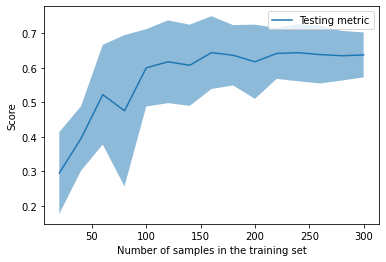

In [ ]:
from sklearn.model_selection import LearningCurveDisplay

model = models['Linear Models'][2].instance

LearningCurveDisplay.from_estimator(
   model, x_all, y_all, train_sizes=list(range(20, int(len(x_all) * 0.8), 20)),
   scoring = 'r2',
   cv=custom_cv_stratified_regression(5, x_all, y_all, test_size = 0.20, random_state = None))

## Partial Dependency 

In [ ]:
x_all.columns

Index(['playingtime', 'rulebook_len', 'dice_luck_metric',
       'drawing_luck_metric', 'shuffling_luck_metric', 'random_luck_metric',
       'can_metric', 'choices_metric', 'entities_count', 'interaction_score',
       'entities_variance', 'actions_score', 'lexical_richness', 'abstracts',
       'cgs', 'childrensgames', 'familygames', 'partygames', 'strategygames',
       'thematic', 'unspecified', 'wargames'],
      dtype='object')

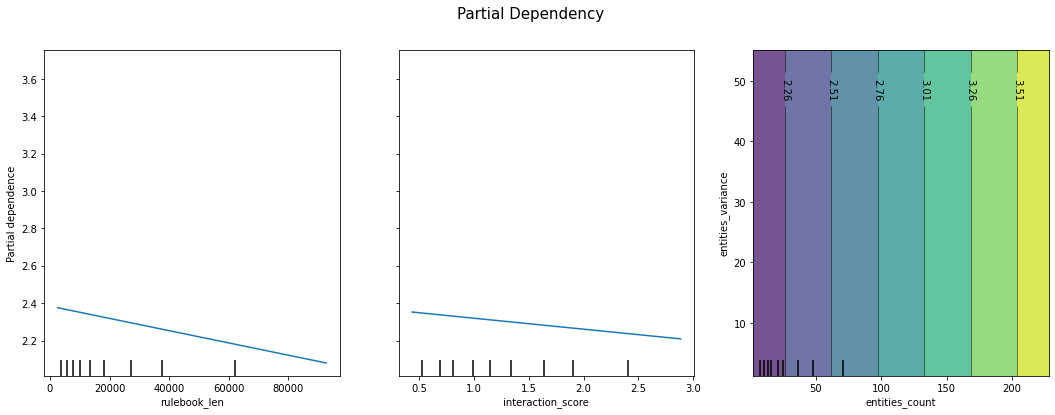

In [ ]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

model = models['Linear Models'][0].instance
model.fit(x_all, y_all)

# fig, ax = create_containing_plot(0, features_count)
# flatten_ax = np.matrix.flatten(ax)

fig, ax = create_containing_plot('Partial Dependency', 0, 3)
PartialDependenceDisplay.from_estimator(model, x_all, ['rulebook_len', 'interaction_score', ('entities_count', 'entities_variance')], ax = ax)
# for i, column in enumerate(x_all.columns):
#     PartialDependenceDisplay.from_estimator(model, x_all, [column], 
#                                             ax=flatten_ax[i], line_kw={"color": "red"})

## Permutation Importance
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled

In [14]:
from sklearn.inspection import permutation_importance

model = models['Support Vector Machines'][0].instance
model.fit(x_all, y_all)

def compute_permutation_importance(model, x, y):
    r = permutation_importance(model, x_all, y_all, n_repeats=30, random_state=1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{x_all.columns[i]:<20}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            
compute_permutation_importance(model, x_all, y_all)

playingtime         0.523 +/- 0.037
strategygames       0.137 +/- 0.014
familygames         0.114 +/- 0.015
entities_variance   0.092 +/- 0.008
rulebook_len        0.084 +/- 0.011
entities_count      0.069 +/- 0.008
random_luck_metric  0.029 +/- 0.009
interaction_score   0.029 +/- 0.007
shuffling_luck_metric0.028 +/- 0.006
partygames          0.012 +/- 0.003


## GridSearch results analysis

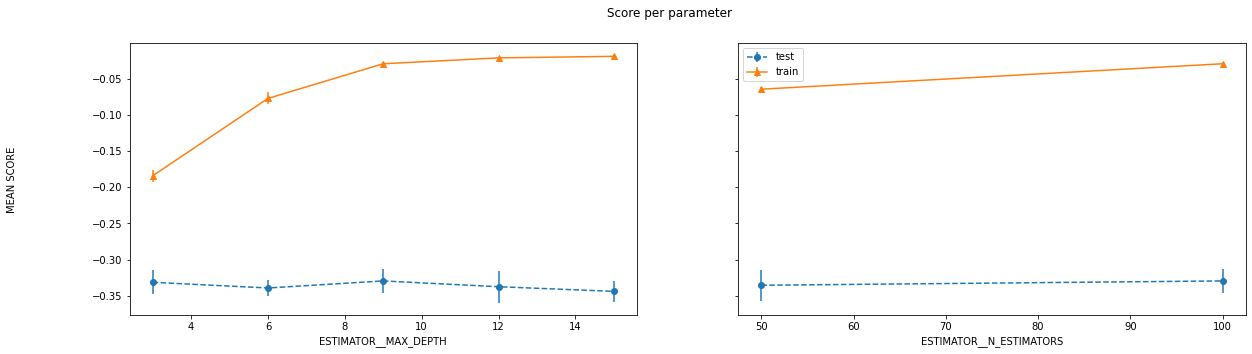

In [ ]:
splitter = custom_cv_stratified_regression(5, x_all, y_all, 
                                           test_size = 0.20, random_state = None)

model = build_model(trf_robust, None, ensemble.GradientBoostingRegressor(loss = 'absolute_error'), {
            'estimator__n_estimators': [50, 100],
            'estimator__max_depth': range(3, 18, 3),
        })

# copied from https://stackoverflow.com/a/57013458/5587393
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

search = GridSearchCV(model.instance,
                      model.params_tuning,
                      cv = splitter,
                      error_score='raise',
                      refit = 'neg_mean_absolute_error',
                      n_jobs = -1, 
                      scoring = 'neg_mean_absolute_error',
                      return_train_score = True)
    
search.fit(x_all, y_all)

plot_search_results(search)

# Predicting

2023-01-25 18:32:09,246 bgg_predict  INFO     Processing model RobustScaler + RFECV(LinearRegression) ...
INFO:bgg_predict:Processing model RobustScaler + RFECV(LinearRegression) ...
2023-01-25 18:32:14,112 bgg_predict  INFO     model RobustScaler + RFECV(LinearRegression) is ready
INFO:bgg_predict:model RobustScaler + RFECV(LinearRegression) is ready
2023-01-25 18:32:14,283 bgg_predict  INFO     Processing model RobustScaler + SelectKBest + SVR ...
INFO:bgg_predict:Processing model RobustScaler + SelectKBest + SVR ...
2023-01-25 18:32:15,259 bgg_predict  INFO     model RobustScaler + SelectKBest + SVR is ready
INFO:bgg_predict:model RobustScaler + SelectKBest + SVR is ready
2023-01-25 18:32:15,327 bgg_predict  INFO     Processing model RobustScaler + SelectKBest + KNeighborsRegressor ...
INFO:bgg_predict:Processing model RobustScaler + SelectKBest + KNeighborsRegressor ...
2023-01-25 18:32:18,286 bgg_predict  INFO     model RobustScaler + SelectKBest + KNeighborsRegressor is ready
INF

Model Validation Scores  \
                                                                   R2   
2                  RobustScaler + SelectKBest + SVR          0.699744   
1  RobustScaler + SelectKBest + KNeighborsRegressor          0.662798   
0            RobustScaler + RFECV(LinearRegression)          0.606605   

                                Testing Scores                                \
        MAE      MAPE       MSE             R2       MAE      MAPE       MSE   
2  0.323246  0.149268  0.185699       0.722791  0.312584  0.141210  0.170951   
1  0.348078  0.161766  0.207697       0.732917  0.321969  0.147327  0.164473   
0  0.379740  0.177050  0.243312       0.673090  0.353832  0.163379  0.200273   

                                              params  
                                                      
2                       {'feature_selector__k': 7.2}  
1  {'estimator__n_neighbors': 12.4, 'feature_sele...  
0                                                 {}

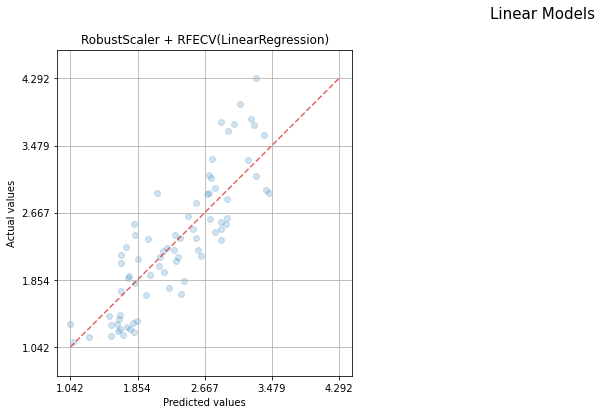

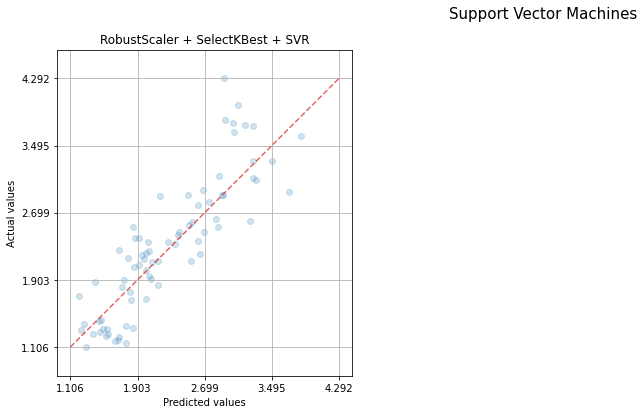

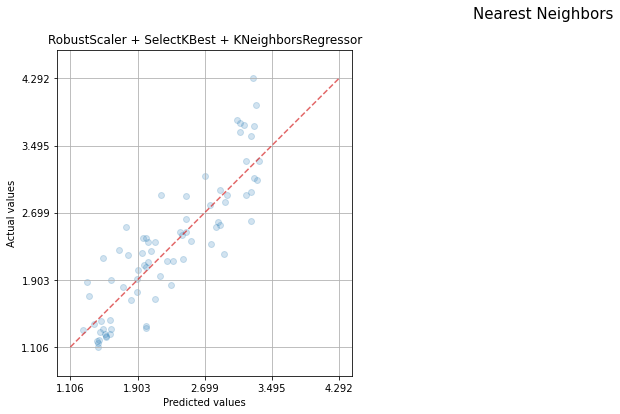

In [12]:
from typing import Optional
from collections import defaultdict
import numpy as np
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def aggregate_results(results):
    def get_mean(x):
        if x.dtype == float:
            return x.mean()
        elif x.dtype == object:
            return x.apply(lambda dic: pd.Series(dic)).mean().to_dict()

    return results.groupby(['Model'], as_index=False).aggregate(get_mean)

def build_new_results(current_results, 
                      round_num: int,
                      model_name: str, 
                      validation_scores: PerformanceMetrics,
                      testing_scores: PerformanceMetrics,
                      best_params: Optional[Dict[str, Any]]):
    return pd.concat([current_results, pd.DataFrame({ 
                ('Model', ''): [model_name], 
                ('Validation Scores', 'R2'): [validation_scores.r2], 
                ('Validation Scores', 'MAE'): [validation_scores.mae], 
                ('Validation Scores',  'MAPE'): [validation_scores.mape],
                ('Validation Scores', 'MSE'): [validation_scores.mse],
                ('Testing Scores', 'R2'): [testing_scores.r2], 
                ('Testing Scores', 'MAE'): [testing_scores.mae], 
                ('Testing Scores',  'MAPE'): [testing_scores.mape],
                ('Testing Scores', 'MSE'): [testing_scores.mse],
                ('params', ''): [best_params]
            }, index = [round_num])])
    
final_estimators: Dict[str, List[Any]] = defaultdict(list)

index = pd.MultiIndex \
    .from_product([['Validation Scores', 'Testing Scores'], ['R2', 'MAE', 'MAPE', 'MSE']]) \
    .insert(0, 'Model').insert(9, 'params')
results = pd.DataFrame(columns=index)
cv_scorings = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

for round_num in range(5):
    x_train, x_test, y_train, y_test = \
        train_test_stratified_split(x_all, y_all,
                                    test_size = 0.20, random_state = 10 * round_num)

    for i_category, (category_name, cat_models) in enumerate(models.items()):
        if len(cat_models) == 0:
            continue

        if round_num == 0:
            fig, ax = create_containing_plot(category_name, i_category, len(cat_models))
        for i_m, model in enumerate(cat_models):
            splitter = custom_cv_stratified_regression(5, x_train, y_train, 
                                                    test_size = 0.20, random_state = 0)
            
            logger.info(f'Processing model {model.name} ...')
            estimator, validation_scores, best_params = \
                get_fit_estimator(model.instance, x_train, y_train, splitter, cv_scorings) \
                    if model.params_tuning is None else \
                get_fit_estimator_with_tuning(model.instance, model.params_tuning, 
                                            x_train, y_train, splitter, cv_scorings)
                
            logger.info(f'model {model.name} is ready')

            y_predictions = estimator.predict(x_test)

            final_estimators[model.name].append(estimator)
            testing_scores = PerformanceMetrics(r2_score(y_test, y_predictions),
                                                mean_absolute_error(y_test, y_predictions),
                                                mean_absolute_percentage_error(y_test, y_predictions),
                                                mean_squared_error(y_test, y_predictions))
            results = build_new_results(results, round_num, model.name,
                                        validation_scores, testing_scores,
                                        best_params)
            
            if round_num == 0:
                fill_predictions_subplot(ax, i_m, model.name, y_test, y_predictions)

aggregate_results(results).sort_values(('Testing Scores', 'MAE'))

## Results Analysis

In [21]:
models_ranking = aggregate_results(results).sort_values(('Testing Scores', 'MAE'))

def get_best_features(model_name: str):
    best_features = list(map(lambda f: int(f[1:]), set().union(*[
        set(estimator['feature_selector'].get_feature_names_out())
        for estimator in final_estimators[model_name]
        ])))
    return [column for i, column in enumerate(x_all.columns) if i in best_features]

# model_name = 'RobustScaler + SelectKBest + SVR'
# print(f'********** {model_name} ***********')
# print(get_best_features(model_name))
# compute_permutation_importance(final_estimators[model_name][0], x_all, y_all)

# model_name = 'RobustScaler + SelectKBest + KNeighborsRegressor'
# print(f'********** {model_name} ***********')
# print(get_best_features(model_name))
# compute_permutation_importance(final_estimators[model_name][0], x_all, y_all)

model_name = 'RobustScaler + RFECV(LinearRegression)'
print(f'********** {model_name} ***********')
best_features = list(sorted(zip(final_estimators[model_name][0]['estimator'].ranking_, x_all.columns), key = lambda x: x[0]))
display(best_features)
best_features = filter(lambda x: x[0] == 1, best_features)
list(sorted(zip(final_estimators[model_name][0]['estimator'].estimator_.coef_, best_features), key = lambda x: x[0]))

# model_name = 'RobustScaler + ExtraTreesRegressor'
# print(f'********** {model_name} ***********')
# list(sorted(zip(final_estimators[model_name][0]['estimator'].feature_importances_, x_all.columns), key = lambda x: x[0]))
# compute_permutation_importance(final_estimators[model_name][0], x_all, y_all)

********** RobustScaler + RFECV(LinearRegression) ***********


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
<ipython-input-12-6edb74e6e677>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return x.apply(lambda dic: pd.Series(dic)).mean().to_dict()


[(1, 'playingtime'),
 (1, 'entities_count'),
 (1, 'abstracts'),
 (1, 'childrensgames'),
 (1, 'familygames'),
 (1, 'partygames'),
 (1, 'strategygames'),
 (1, 'unspecified'),
 (2, 'rulebook_len'),
 (3, 'wargames'),
 (4, 'thematic'),
 (5, 'cgs'),
 (6, 'drawing_luck_metric'),
 (7, 'random_luck_metric'),
 (8, 'interaction_score'),
 (9, 'entities_variance'),
 (10, 'choices_metric'),
 (11, 'dice_luck_metric'),
 (12, 'lexical_richness'),
 (13, 'shuffling_luck_metric'),
 (14, 'actions_score'),
 (15, 'can_metric')]

[(-0.5883251965422113, (1, 'partygames')),
 (-0.5338195770437736, (1, 'familygames')),
 (-0.5276638373785092, (1, 'childrensgames')),
 (-0.31820162658866863, (1, 'unspecified')),
 (-0.21594201361755833, (1, 'abstracts')),
 (0.10096685269032818, (1, 'entities_count')),
 (0.2503712270205255, (1, 'playingtime')),
 (0.5340421936141367, (1, 'strategygames'))]